In [1]:
import time
import random
import numpy as np
from collections import deque
import gym
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
import tensorflow as tf
import tensorflow.keras.layers as L
import tensorflow.keras.models as M

import matplotlib.pyplot as plt
%matplotlib inline
print(tf.__version__)

2.9.1


In [2]:
# Проверяем что у нас работает GPU
tf.test.gpu_device_name()

'/device:GPU:0'

In [3]:
#GPU count and name
!nvidia-smi

/bin/bash: /home/greg/anaconda3/envs/tf/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Sun Aug 14 13:10:55 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.65.01    Driver Version: 515.65.01    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0  On |                  N/A |
|  0%   58C    P2    79W / 350W |    866MiB / 12288MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+-------------------

### Load GYM environment

In [4]:
env = gym.make('CartPole-v0')

STATE_LIMITS = env.observation_space
NUM_ACTIONS = env.action_space.n

print('Actions: {}'.format(NUM_ACTIONS))
print('States limits:')
for i in range(STATE_LIMITS.shape[0]):
    print('[{}, {}]'.format(STATE_LIMITS.low[i], STATE_LIMITS.high[i]))

Actions: 2
States limits:
[-4.800000190734863, 4.800000190734863]
[-3.4028234663852886e+38, 3.4028234663852886e+38]
[-0.41887903213500977, 0.41887903213500977]
[-3.4028234663852886e+38, 3.4028234663852886e+38]


### Settings

In [5]:
LR = 0.001
gamma = 0.99
replay_experience_maxlen = 50000
batch_size = 64
NUM_EPISODES = 1000
MAX_STEPS = 200
REWARD_AVERAGE_WINDOW = 50

### DQN Model

In [6]:
model = M.Sequential([
    L.Dense(24, activation='relu'),
    L.Dense(24, activation='relu'),
    L.Dense(NUM_ACTIONS, activation=None, use_bias=False),
])

In [7]:
def evalQ(s):
    return model(s[None, ...].astype(np.float32)).numpy()[0]

### Prepare model for training

In [8]:
# def loss(q1, q2):
#     return tf.reduce_sum(tf.square(q1 - q2))
# optimizer = tf.train.GradientDescentOptimizer(learning_rate=lr)
# model.compile(loss=loss, optimizer=optimizer)

optimizer = tf.keras.optimizers.Adam(learning_rate=LR)
model.compile(loss='mse', optimizer=optimizer)

In [9]:
pathLenList = []
totalRewardList = []
totalRewardAverageList = []

In [10]:
s = env.reset()
print(type(s))
print(len(s))
print(s)
print(s[None, ...])

<class 'numpy.ndarray'>
4
[ 0.00294177  0.0314798   0.01904531 -0.01151615]
[[ 0.00294177  0.0314798   0.01904531 -0.01151615]]


### DQN training

In [11]:
# Initialize empty experiences
replay_experience = deque(maxlen=replay_experience_maxlen)

In [12]:
totalRewardAverage = 0
for i in range(NUM_EPISODES):
    
    eps = 1./((i/50) + 10)
    
    s = env.reset()
    
    totalReward = 0
    step = 0
    done = False
    
    while not done and (step < MAX_STEPS):
        step += 1

        Q_s = evalQ(s)
        
        if np.random.rand() < eps:
            a = env.action_space.sample()
        else:
            a = np.argmax(Q_s)

        s1, r, done, _ = env.step(a)
        
        totalReward += r

        if done:
            r = -1.0
        
        # Save experience
        replay_experience.append([s, a, r, s1, done])      
        
        s = s1
        
        # Do training if replay_experience contains enough sample > batch_size
        if len(replay_experience) > batch_size:
            ## 1- Sample from replay experience
            batch = random.sample(replay_experience, batch_size)
            
            states = np.vstack([x[0] for x in batch])
            actions = np.array([x[1] for x in batch])
            rewards = np.array([x[2] for x in batch])
            next_states = np.vstack([x[3] for x in batch])
            episodes_done = np.array([x[4] for x in batch])
            
            target_Q = evalQ(states)
            
#             target_Q = Q.eval(feed_dict={X: states})
            
            target_Q[range(batch_size), actions] = rewards + \
                                                   gamma * np.max(evalQ(next_states), axis=1) * ~episodes_done
            
#             train_step.run(feed_dict={X: states, y: target_Q})            
            
#             Q_s1 = evalQ(s1)
        
#             Q_target = Q_s
            
            #             Q_target[a] = r
            
#             Q_target[a] = r + gamma * np.max(Q_s1)
 
            model.train_on_batch(states, target_Q)
            
#             model.train_on_batch(s[None, ...].astype(np.float32), Q_target[None, ...])

        
            
    pathLenList.append(step)
    totalRewardList.append(totalReward)

    if i % REWARD_AVERAGE_WINDOW == 0 and i >= REWARD_AVERAGE_WINDOW:
        totalRewardAverage = np.mean(totalRewardList[-REWARD_AVERAGE_WINDOW:])
        totalRewardAverageList.append(totalRewardAverage)
        if i % 100 == 0:
            print('Episode {}: average total reward = {}'.format(i, totalRewardAverage))
            
    if totalRewardAverage > 199:
        break

Episode 100: average total reward = 162.12
Episode 200: average total reward = 199.72


## Plot trajectory length over time

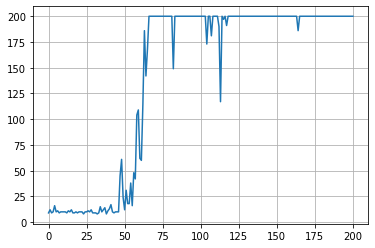

In [13]:
plt.plot(pathLenList)
plt.grid()

## Plot average total reward over time

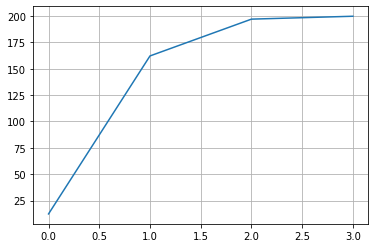

In [14]:
plt.plot(totalRewardAverageList)
plt.grid()

In [15]:
RECORD_VIDEO = False # True

if RECORD_VIDEO:
  
    !pip install pyvirtualdisplay > /dev/null 2>&1
    !apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1

    from pyvirtualdisplay import Display
    display = Display(visible=0, size=(1400, 900))
    display.start()

## Run simulation

In [17]:
USE_Q = True

if RECORD_VIDEO:
    from gym.wrappers import Monitor
    env_sim = Monitor(env, './video', force=True)
else:
    env_sim = env

print("Play 20 times with optimal policy")    
for i in range(20):    
    
    s = env_sim.reset()
    totalReward = 0

    for _ in range(1000):
        env_sim.render()
        if USE_Q:
            a = np.argmax(evalQ(s))
        else:
            a = env_sim.action_space.sample()    
        s, r, done, _ = env_sim.step(a)
        totalReward += r
        if done:
            break
       
        if not RECORD_VIDEO:
            time.sleep(1./30)
        
    env_sim.close()

    print('Total reward = {}'.format(totalReward))

Play 20 times with optimal policy
Total reward = 200.0
Total reward = 200.0
Total reward = 200.0
Total reward = 200.0
Total reward = 200.0
Total reward = 200.0
Total reward = 200.0
Total reward = 200.0
Total reward = 200.0
Total reward = 200.0
Total reward = 200.0
Total reward = 200.0
Total reward = 200.0
Total reward = 200.0
Total reward = 200.0
Total reward = 200.0
Total reward = 200.0
Total reward = 200.0
Total reward = 200.0
Total reward = 200.0


## Show the video

In [ ]:
# def show_video():
#     import glob
#     import io
#     import base64
#     from IPython.display import HTML
#     from IPython import display as ipythondisplay

#     mp4list = glob.glob('video/*.mp4')
#     if len(mp4list) > 0:
#         mp4 = mp4list[0]
#         video = io.open(mp4, 'r+b').read()
#         encoded = base64.b64encode(video)
#         ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
#             loop controls style="height: 400px;">
#             <source src="data:video/mp4;base64,{0}" type="video/mp4" />
#             </video>'''.format(encoded.decode('ascii'))))
#     else: 
#         print("Could not find video")
    
# show_video()

In [ ]:
# как видим, задача увы не решена - в итоге уходим за допустимые границы игры. 
# А нам нужно, чтоб она смогла стоять не ограниченное время (как это было на видео)
# в этом и есть наша задача в ДЗ